<a href="https://colab.research.google.com/github/cassmasschelein/CHEM-3RP3/blob/master/Introduction_to_ML_Shantal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment**: Designing and Tuning a Convolutional Neural Network (CNN)

**Assignment Description**: There are four parts to this assignment

1.   Building a CNN
2.   Training and Tuning a CNN
3.   Trying Out a New Dataset
4.   Open-Ended Exploration

You will be largely guided through the first two parts. The third and fourth part are discussion based questions. 

**Before the experiment, make sure that you have GPU enabled. This setting can be found under *Tools --> Settings***

In [87]:
#Install Objax
!pip --quiet install  objax
import objax

In [88]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np
import jax.numpy as jn
import random 
import matplotlib.pyplot as plt

##**Part 1. Building a CNN** 

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

Do not change split ratio for now.

In [61]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

In [63]:
print(X_train.shape)
print(X_train.shape[0])

(48000, 3, 32, 32)
48000



Next we will construct a **Base Model**, which in our case is a small CNN.

In [36]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()

Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, you will take the first very image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns. 



TypeError: ignored

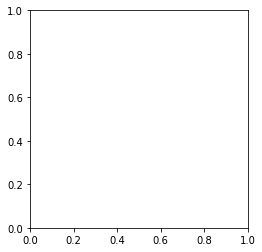

In [60]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0))

Next, we will pass our image through Objax's convolution routine. Carefully examine the following code and try to understand the dimension of the filter weights and the output. 

In [38]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)

#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now

net = Conv2d(my_image)

print("Filter weights:", filter_weights)
print("Filter weights:", filter_weights)
print("Filter weights size:", np.shape(filter_weights))
print("Conv output:", net)
print("Conv output shape:", np.shape(Conv2d(my_image)))
print("Check the mean:", net.mean((2,3)))

Filter weights: [[[[ 0.49025118 -0.6209711 ]
   [ 0.35629547 -0.447931  ]
   [-0.18546179  0.69134593]]]]
Filter weights: [[[[ 0.49025118 -0.6209711 ]
   [ 0.35629547 -0.447931  ]
   [-0.18546179  0.69134593]]]]
Filter weights size: (1, 1, 3, 2)
Conv output: [[[[ 0.07214503  0.06955255  0.06250238 ...  0.33166018  0.3281318
     0.32839116]
   [ 0.09806993  0.08371025  0.08842728 ...  0.36716136  0.362323
     0.35973048]
   [ 0.10066241  0.08510748  0.10138971 ...  0.40283462  0.39461914
     0.38393244]
   ...
   [ 0.11406954  0.10888456  0.10888456 ...  0.17872815  0.18132064
     0.1890981 ]
   [ 0.09592212  0.09073714  0.09073714 ...  0.19428308  0.1916906
     0.1916906 ]
   [ 0.08555216  0.08295967  0.08555216 ...  0.23057793  0.22798543
     0.22020797]]

  [[-0.04619769 -0.04471708 -0.0429864  ... -0.02560312 -0.03009675
    -0.03579508]
   [-0.0610038  -0.05184416 -0.05779251 ... -0.07226776 -0.06970592
    -0.06822532]
   [-0.06248442 -0.05360074 -0.06519558 ... -0.12992959 

**In the cells below, you will create your own convolution routine that takes in the image and the initial weights used by Objax's own convolution routine (Conv2d.w.value) and show that your convolution routine returns the same value than Objax's.**

A simple implementation only requires 4 FOR loops. You may wish to draw inspiration from https://objax.readthedocs.io/en/latest/objax/nn.html?highlight=objax.nn.Conv2D#objax.nn.Conv2D

In [39]:
#Solution to the above problem

def my_conv_net(my_image, initial_filter_weights):
  "PUT YOUR CODE HERE"
  strides = 1

  # Retrieve dimensions from images shape  
  (m, n_C_prev, n_H_prev, n_W_prev) = my_image.shape
    
  # Retrieve dimensions from filter weight shape
  (f, f, n_C_prev, n_C) = initial_filter_weights.shape
    
  # Compute the dimensions of the CONV output
  n_H = int((n_H_prev - f)/strides) + 1
  n_W = int((n_W_prev - f)/strides) + 1

  # Initialize the output volume Z with zeros
  Z = np.zeros((m, n_C, n_H, n_W))

  for n in range(m):
    for c in range(n_C): # loop over new channels
      for h in range(n_H): # loop over vertical axis of output
        for w in range(n_W): # loop over horizontal axis of output    
          a_slice_prev_no_pad = my_image[n,:,h:(h+f),w:(w+f)]

          # Convolve the slice 
          Z[n, c, h, w] = np.sum(np.multiply(initial_filter_weights[:,:,:,c].transpose([2,0,1]), a_slice_prev_no_pad))

  my_conv_output = Z

  return my_conv_output

In [40]:
print(filter_weights)

[[[[ 0.49025118 -0.6209711 ]
   [ 0.35629547 -0.447931  ]
   [-0.18546179  0.69134593]]]]


In [41]:
my_nn = my_conv_net(my_image, filter_weights)
print("dtype:", my_nn.dtype)
print("My Conv output:", my_nn)
print("My Conv output shape:", np.shape(my_nn))
print(np.size(net)==np.size(my_nn))
print(np.all(abs(np.subtract(net, my_nn)) < 0.0000001))
#print(np.array_equal((abs(np.subtract(net, my_nn)) < 0.00000001),(abs(np.subtract(net, my_nn)) < 0.0000000001)))

#print(np.array_equal(Conv2d(my_image)[:,:,:,:], my_conv_net(my_image, filter_weights)[:,:,:,:]))


#np.array_equal(my_nn,net)
#print(my_nn[:,:,:,:]==net[:,:,:,:])

dtype: float64
My Conv output: [[[[ 0.07214503  0.06955254  0.06250237 ...  0.3316602   0.32813181
     0.32839116]
   [ 0.09806993  0.08371024  0.08842727 ...  0.36716136  0.36232298
     0.35973049]
   [ 0.10066242  0.08510748  0.10138972 ...  0.40283461  0.39461908
     0.38393241]
   ...
   [ 0.11406954  0.10888457  0.10888457 ...  0.17872814  0.18132063
     0.18909809]
   [ 0.09592212  0.09073714  0.09073714 ...  0.19428307  0.19169058
     0.19169058]
   [ 0.08555216  0.08295967  0.08555216 ...  0.23057793  0.22798544
     0.22020797]]

  [[-0.04619768 -0.04471707 -0.0429864  ... -0.02560308 -0.03009675
    -0.03579505]
   [-0.06100381 -0.05184415 -0.05779252 ... -0.07226774 -0.06970593
    -0.06822532]
   [-0.06248442 -0.05360075 -0.06519558 ... -0.12992958 -0.11951027
    -0.10422379]
   ...
   [-0.06514694 -0.06218572 -0.06218572 ... -0.13610838 -0.13758899
    -0.14203083]
   [-0.05478266 -0.05182143 -0.05182143 ... -0.14499205 -0.14351144
    -0.14351144]
   [-0.04886021 -0

The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Check that calling .mean((2,3)) rearranges the output of your convolution routine by examining the shape of the output. (Not graded) Think about alternative ways of rearranging the output from the convolution layer. 

In [42]:
#Check that .mean((2,3)) rearranges your image
np.shape(my_nn.mean((2,3)))

(1, 2)

Take your rearranged output and feed it into a linear layer of appropriate size. Here is an example:

```
Linear_Layer = objax.nn.Linear(N, 1)
Y = Linear_Layer(X)
```
Next, extract the weights and bias of the linear layer using 
```
Linear_Layer.w.value
Linear_Layer.b.value
```
**Using these values, write one line of code that manually implements the linear layer. Show that it provides the same value as Objax's own linear layer.** 



In [43]:
#PUT YOUR CODE HERE
X = net.mean((2,3))
Linear_Layer = objax.nn.Linear(2, 1)
Y = Linear_Layer(X)
weights = Linear_Layer.w.value
bias = Linear_Layer.b.value

# Manually implement the linear layer
Z = Linear_Layer.b.value + np.sum(np.multiply(X[0,:],Linear_Layer.w.value[:,0]))

# Check that it provides the same value
print(Y==Z)
print(np.all(Y==Z))


[[ True]]
True


You have now completed Part 1 of the assignment. Good job!


##**Part 2. Training and Tuning a CNN**

The following starter code trains the neural network in Part 1. However, the optimizer and batch sampling routine are left for you to implement. Complete the lines that says #PUT YOUR CODE HERE#

Afterwards, train the model, and observe the training/validation loss and accuracy plots. You should observe that the validation accuracy is low and stagnates after a few epochs.

In [44]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      params.value = params.value - lr * grad
      ####################                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [45]:
def train(EPOCHS = 25, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.88 Validation Accuracy 10.03
Epoch 0002  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 9.78 Validation Accuracy 10.02
Epoch 0003  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 9.90 Validation Accuracy 10.32
Epoch 0004  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.52 Validation Accuracy 10.58
Epoch 0005  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.49 Validation Accuracy 11.25
Epoch 0006  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 11.10 Validation Accuracy 10.77
Epoch 0007  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.10 Validation Accuracy 11.62
Epoch 0008  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.50 Validation Accuracy 12.08
Epoch 0009  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 11.84 Validation Accuracy 12.25
Epoch 0010  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 12.33 Validatio

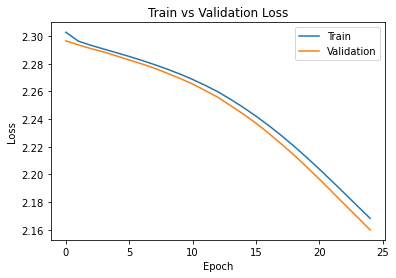

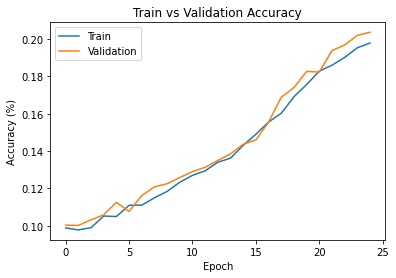

In [14]:
train()

Follow the assignment handout for questions to be answered in this part of the assignment.

In [46]:
#PUT YOUR CODE HERE (Use as many cells as you want)

#Hyperparameters to tune: learning rate, batch size, stride value for CNN, number of conv layers)

H1 = {0.01, 32, 1, 3}
H2 = {0.1, 64, 2, 2}

#Let's implement and train M1
# M1 with H1 hyperparameters
class ConvNet_H1(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 24, 2, strides=1), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(24, 16, 2, strides=1), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2, strides=1), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = objax.functional.max_pool_2d(self.conv_2(x), 2, 2)
    x = self.conv_3(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
M1 = ConvNet_H1()

#Train M1
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = M1(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(M1(x)), M1.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, M1.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in M1.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      params.value = params.value - lr * grad
      ####################                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())


def train_M1(EPOCHS = 25, BATCH = 32, LEARNING_RATE = 0.01):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.29 Validation Loss 2.25 Training Accuracy 14.56 Validation Accuracy 16.85
Epoch 0002  Training Loss 2.15 Validation Loss 2.08 Training Accuracy 20.79 Validation Accuracy 22.08
Epoch 0003  Training Loss 2.07 Validation Loss 2.04 Training Accuracy 25.53 Validation Accuracy 25.43
Epoch 0004  Training Loss 2.01 Validation Loss 1.97 Training Accuracy 27.91 Validation Accuracy 27.15
Epoch 0005  Training Loss 1.94 Validation Loss 1.92 Training Accuracy 30.68 Validation Accuracy 27.92
Epoch 0006  Training Loss 1.88 Validation Loss 1.91 Training Accuracy 32.66 Validation Accuracy 27.93
Epoch 0007  Training Loss 1.85 Validation Loss 1.86 Training Accuracy 33.94 Validation Accuracy 30.25
Epoch 0008  Training Loss 1.82 Validation Loss 1.79 Training Accuracy 35.26 Validation Accuracy 32.52
Epoch 0009  Training Loss 1.79 Validation Loss 1.75 Training Accuracy 36.29 Validation Accuracy 34.55
Epoch 0010  Training Loss 1.76 Validation Loss 1.80 Training Accuracy 37.84 Valida

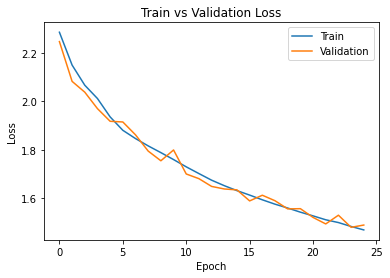

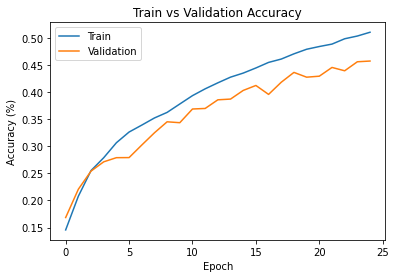

In [30]:
train_M1()

In [47]:
#Let's implement and train M2
# M2 with H2 hyperparameters
class ConvNet_H2(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
M2 = ConvNet_H2()

#Train M2
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = M2(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(M2(x)), M2.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, M2.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in M2.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      params.value = params.value - lr * grad
      ####################                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

def train_M2(EPOCHS = 25, BATCH = 64, LEARNING_RATE = 0.1):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.14 Validation Loss 2.04 Training Accuracy 23.36 Validation Accuracy 23.38
Epoch 0002  Training Loss 2.01 Validation Loss 1.93 Training Accuracy 29.32 Validation Accuracy 28.20
Epoch 0003  Training Loss 1.92 Validation Loss 1.86 Training Accuracy 32.67 Validation Accuracy 31.27
Epoch 0004  Training Loss 1.87 Validation Loss 1.84 Training Accuracy 34.53 Validation Accuracy 32.12
Epoch 0005  Training Loss 1.83 Validation Loss 1.78 Training Accuracy 36.55 Validation Accuracy 34.53
Epoch 0006  Training Loss 1.79 Validation Loss 1.73 Training Accuracy 38.13 Validation Accuracy 36.05
Epoch 0007  Training Loss 1.75 Validation Loss 1.87 Training Accuracy 39.77 Validation Accuracy 30.87
Epoch 0008  Training Loss 1.72 Validation Loss 1.70 Training Accuracy 41.39 Validation Accuracy 37.68
Epoch 0009  Training Loss 1.68 Validation Loss 1.89 Training Accuracy 42.67 Validation Accuracy 30.32
Epoch 0010  Training Loss 1.66 Validation Loss 1.66 Training Accuracy 44.12 Valida

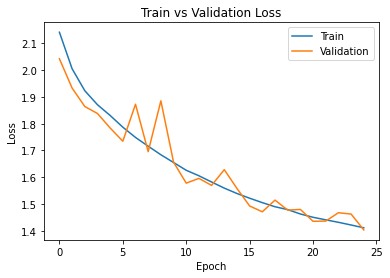

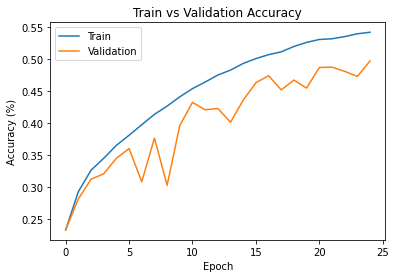

In [28]:
train_M2()

In [ ]:
#The best model is .... - now evaluate the test accuracy

You have now completed Part 2 of the assignment. Good job!


##**Part 3. Trying Out a New Dataset**

See the handout for instructions.


In [89]:
#Use MNIST dataset - import and partition the data

#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train[:,None,:,:] / 255.0
Y_train = Y_train.flatten()
X_test = X_test[:,None,:,:] / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

In [90]:
print(X_train.shape)

(56000, 1, 28, 28)


In [96]:
#Create a BASE MODEL for the new dataset
class ConvNet2(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 32, 5), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 5), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 64, 5), objax.functional.relu])
    self.conv_4 = objax.nn.Sequential([objax.nn.Conv2D(64, number_of_classes, 1), objax.functional.relu])
    
  def __call__(self, x):
    x = objax.functional.average_pool_2d(self.conv_1(x), size=2, strides=1)
    x = objax.functional.average_pool_2d(self.conv_2(x), size=2, strides=1)
    x = objax.functional.average_pool_2d(self.conv_3(x), size=2, strides=1)

    x = self.conv_4(x)
    x = x.mean((2,3)) #<--- global average pooling 

    return x

#The following line creates the CNN
model = ConvNet2()
#You can examine the architecture of our CNN by calling model.vars()

UnexpectedTracerError: ignored

(56000, 1, 28, 28)
56000


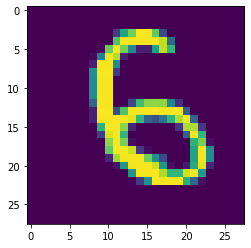

In [97]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0,0])
print(np.shape(X_train))
print(X_train.shape[0])

In [98]:
#Tune and train the model
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      params.value = params.value - lr * grad
      ####################                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [99]:
def train(EPOCHS = 10, BATCH = 50, LEARNING_RATE = 0.001):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

In [100]:
train()

UnexpectedTracerError: ignored

In [101]:
#Hyperparameters to tune - learning rate, batch size, number of conv layers
#Explore learning rates between 0.1 and 0.001 [0.1, 0.01, 0.001]
#Explore batch sizes between 30 to 75 in increments of 15 [30,45,60,75]
#Explore the number of convolution layers [3,4,5]
#Use random search to explore the hyperparameters so that it is less expensive
#We also do not want to have too many parameters bc then our model can memorize
#Here I train many models with different random combinations of hyperparameter
#values
#Pick the combination that achieves minimal validation
#I will try four combinations:
H_1 = {0.1, 75, 3}
H_2 = {0.1, 45, 4}
H_3 = {0.01, 45, 4}
H_4 = {0.001, 60, 5}


#Let's implement and train the first combination
# H1 hyperparameters {0.1, 75, 3}
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 32, 5), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(32, 64, 5), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(64, number_of_classes, 1), objax.functional.relu])
    
  def __call__(self, x):
    x = objax.functional.average_pool_2d(self.conv_1(x), size=2, strides=1)
    x = objax.functional.average_pool_2d(self.conv_2(x), size=2, strides=1)

    x = self.conv_3(x)
    x = x.mean((2,3)) #<--- global average pooling 

    return x

#The following line creates the CNN
M1 = ConvNet()

#Tune and train M1
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = M1(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(M1(x)), M1.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, M1.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in M1.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      params.value = params.value - lr * grad
      ####################                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())


def train_M1(EPOCHS = 25, BATCH = 75, LEARNING_RATE = 0.1):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()


UnexpectedTracerError: ignored

In [ ]:
train_M1()

In [ ]:
H_1 = {0.1, 75, 3}
H_2 = {0.1, 45, 4}
H_3 = {0.01, 45, 4}
H_4 = {0.001, 60, 5}

#Let's implement and train the second combination H_2
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 32, 5), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 5), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 64, 5), objax.functional.relu])
    self.conv_4 = objax.nn.Sequential([objax.nn.Conv2D(64, number_of_classes, 1), objax.functional.relu])
    
  def __call__(self, x):
    x = objax.functional.average_pool_2d(self.conv_1(x), size=2, strides=1)
    x = objax.functional.average_pool_2d(self.conv_2(x), size=2, strides=1)
    x = objax.functional.average_pool_2d(self.conv_3(x), size=2, strides=1)

    x = self.conv_4(x)
    x = x.mean((2,3)) #<--- global average pooling 

    return x

#The following line creates the CNN
M2 = ConvNet()

#Tune and train M1
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = M2(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(M2(x)), M2.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, M2.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in M2.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      params.value = params.value - lr * grad
      ####################                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())


def train_M2(EPOCHS = 25, BATCH = 45, LEARNING_RATE = 0.1):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()


In [ ]:
train_M2()

In [ ]:
H_1 = {0.1, 75, 3}
H_2 = {0.1, 45, 4}
H_3 = {0.01, 45, 4}
H_4 = {0.001, 60, 5}

#Let's implement and train the third combination H_3
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 32, 5), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 5), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 64, 5), objax.functional.relu])
    self.conv_4 = objax.nn.Sequential([objax.nn.Conv2D(64, number_of_classes, 1), objax.functional.relu])
    
  def __call__(self, x):
    x = objax.functional.average_pool_2d(self.conv_1(x), size=2, strides=1)
    x = objax.functional.average_pool_2d(self.conv_2(x), size=2, strides=1)
    x = objax.functional.average_pool_2d(self.conv_3(x), size=2, strides=1)

    x = self.conv_4(x)
    x = x.mean((2,3)) #<--- global average pooling 

    return x

#The following line creates the CNN
M3 = ConvNet()

#Tune and train M1
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = M3(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(M3(x)), M3.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, M3.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in M3.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      params.value = params.value - lr * grad
      ####################                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())


def train_M3(EPOCHS = 25, BATCH = 45, LEARNING_RATE = 0.01):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()


In [ ]:
train_M3()

In [ ]:
H_1 = {0.1, 75, 3}
H_2 = {0.1, 45, 4}
H_2 = {0.01, 45, 4}
H_2 = {0.001, 60, 5}

#Let's implement and train the fourth combination
# T1 with H1 hyperparameters {0.1, 75, 3}
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 32, 5), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 5), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 64, 5), objax.functional.relu])
    self.conv_4 = objax.nn.Sequential([objax.nn.Conv2D(64, 20, 2), objax.functional.relu])
    self.conv_5 = objax.nn.Sequential([objax.nn.Conv2D(20, number_of_classes, 1), objax.functional.relu])
    
  def __call__(self, x):
    x = objax.functional.average_pool_2d(self.conv_1(x), size=2, strides=1)
    x = objax.functional.average_pool_2d(self.conv_2(x), size=2, strides=1)
    x = objax.functional.average_pool_2d(self.conv_3(x), size=2, strides=1)
    x = objax.functional.average_pool_2d(self.conv_4(x), size=2, strides=1)

    x = self.conv_5(x)
    x = x.mean((2,3)) #<--- global average pooling 

    return x

#The following line creates the CNN
M4 = ConvNet()

#Tune and train M1
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = M4(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(M4(x)), M4.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, M4.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in M4.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      params.value = params.value - lr * grad
      ####################                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())


def train_M4(EPOCHS = 25, BATCH = 60, LEARNING_RATE = 0.001):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()


In [ ]:
train_M4()

In [ ]:
#Select best model and report test accuracy

In [ ]:
#PART 4 QUESTION 2 - How do hyperparameters interact



##**Problem 4. Open-Ended Exploration**

See the handout for instructions.